In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

Base = automap_base()

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base.prepare(autoload_with=engine)
# reflect the tables
tables = Base.classes

In [6]:
# View all of the classes that automap found
tables.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = tables.measurement
Station = tables.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# View the column headers and first row data
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x14812c57390>,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0}

In [10]:
# Find the most recent date in the data set.
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date

('2017-08-23',)

In [11]:
prev_year = dt.date.fromisoformat(max_date[0]) - dt.timedelta(days=365)
print(prev_year)

2016-08-23


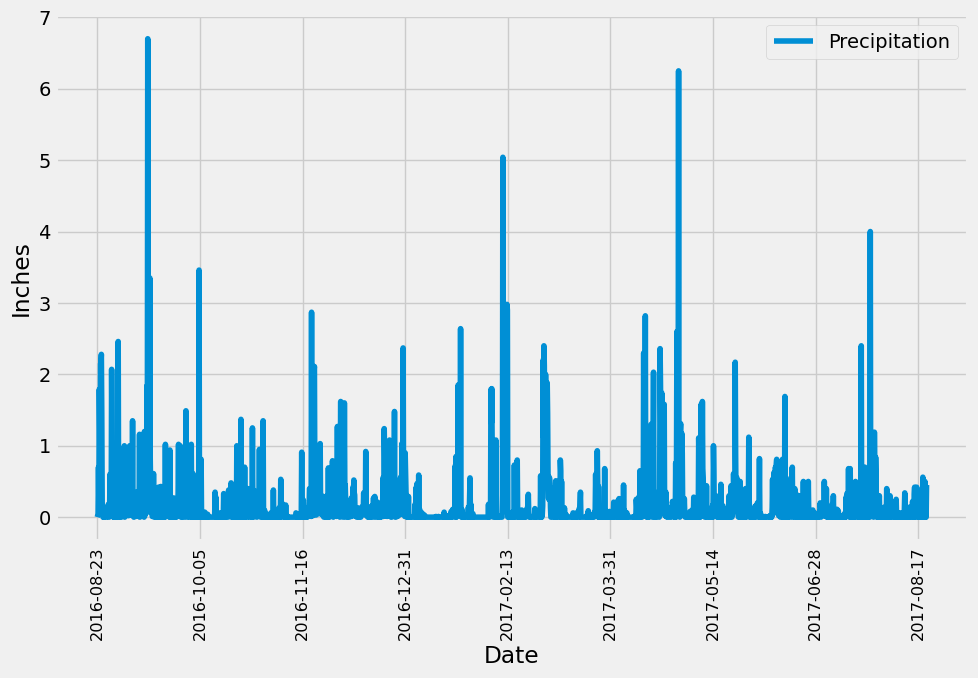

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
past_year = dt.date.fromisoformat(max_date[0]) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
annum_prcp = session.query(Measurement.date,Measurement.prcp)\
            .filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
annum_prcp_df = pd.DataFrame(annum_prcp, columns=['Date','Precipitation']).set_index("Date").dropna(how="any")

# Sort the dataframe by date
annum_prcp_df = annum_prcp_df.sort_values("Date")
annum_prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
annum_prcp_df.plot(ylabel="Inches", grid=True, figsize=(10,7))
plt.xticks(rotation=90, size="small")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("Output_Files/prcp_chart.png")
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
annum_prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# View the column headers and first row data
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x14812c57390>,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0}

In [15]:
# Design a query to calculate the total number of stations in the dataset
unique_stations = session.query(Measurement.station).distinct().count()
print(unique_stations)

9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Measurement.station,
                                 func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
print(station_activity)
print("")
print("Which station id has the greatest number of observations?")
print("*"*20)
print(f"The station with the greatest number of observations is {station_activity[0][0]}, with {station_activity[0][1]} observations.")

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]

Which station id has the greatest number of observations?
********************
The station with the greatest number of observations is USC00519281, with 2772 observations.


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_temps = session.query(func.min(Measurement.tobs),
                             func.max(Measurement.tobs),
                             func.avg(Measurement.tobs)).\
                            filter(Measurement.station == station_activity[0][0]).all()
print(station_temps)
print("")
print(f"Temperature's for the most active station: {station_activity[0][0]}")
print("-"*20)
print(f"Lowest temperature: {station_temps[0][0]}")
print("-"*20)
print(f"Highest temperature: {station_temps[0][1]}")
print("-"*20)
print(f"Average temperature: {round(station_temps[0][2],2)}")

[(54.0, 85.0, 71.66378066378067)]

Temperature's for the most active station: USC00519281
--------------------
Lowest temperature: 54.0
--------------------
Highest temperature: 85.0
--------------------
Average temperature: 71.66


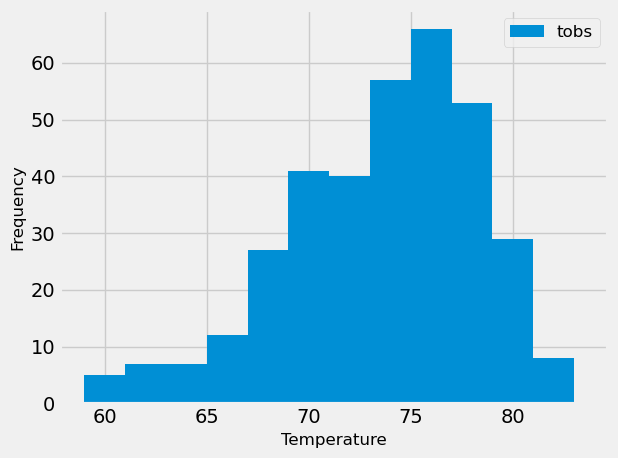

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_hist = session.query(Measurement.tobs).\
                            filter(Measurement.station == station_activity[0][0]).\
                            filter(Measurement.date >= prev_year).\
                            all()

temp_list = [ah[0] for ah in active_hist]

plt.hist(temp_list, bins=12, label="tobs")
plt.legend(loc="best",prop={"size":12})
plt.xlim(min(temp_list)*0.98,max(temp_list)*1.02)
plt.xlabel("Temperature",size=12)
plt.ylabel("Frequency", size=12)
plt.tight_layout()
plt.savefig("Output_Files/temp_hist.png")
plt.show()

# Close Session

In [19]:
# Close Session
session.close()